# Interconnect Churn Model

Interconnect needs to be able to predict the churn of their customers to be able to give promotions and special plan options in hopes of saving customers. I will explore the data provided by their marketing team and train a few models to be able to predict customer churn. The goal is to recieve a AUC-ROC score above 0.88 on the training set. I will also check the accuracy to compare.

## Importing Libraries

In [1]:
import pandas as pd

import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance
from catboost import CatBoostClassifier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

C:\Users\rober\AppData\Local\Temp\ipykernel_14324\1225062909.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Reading in data

In [3]:
try:
    contract = pd.read_csv('C:/Users/rober/OneDrive/Documents/DataScienceBootcamp/Final Project/final_provider/contract.csv')
    internet = pd.read_csv('C:/Users/rober/OneDrive/Documents/DataScienceBootcamp/Final Project/final_provider/internet.csv')
    personal = pd.read_csv('C:/Users/rober/OneDrive/Documents/DataScienceBootcamp/Final Project/final_provider/personal.csv')
    phone = pd.read_csv('C:/Users/rober/OneDrive/Documents/DataScienceBootcamp/Final Project/final_provider/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
# Checking first 5 rows of contract
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
# Checking first 5 rows of internet
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
# Checking first 5 rows of personal
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
# Checking first 5 rows of phone
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [8]:
# Checking contract info
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
# Checking internet info
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
# Checking personal info
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
# Checking phone info
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Notes for pre-processing:
<ul>
    <li>The best way to handle this data will be to combine these DataFrames.</li>
    <li>The phone and internet DataFrames have less rows than contract and personal because some customers don't have phone and internet.</li>
    <li>When I combine the datasets this will cause missing values.</li>
    <li>These values can be filled with 'No' to indicate that the customers don't have those services.</li>
    <li>I will change all of the column names to snake case before making any other changes.</li>
    <li>BeginDate and EndDate need to be changed to DateTime type.</li>
    <li>I will need to extract the target data from EndDate first.</li>
    <li>TotalCharges should be float type</li>
</ul>

## Data Pre-Processing

In [12]:
# Merging DataFrames
interconnect_full = pd.merge(contract, internet, how='left', on='customerID')
interconnect_full = pd.merge(interconnect_full, personal, how='left', on='customerID')
interconnect_full = pd.merge(interconnect_full, phone, how='left', on='customerID')

In [13]:
# Checking first 5 rows of interconnect_full
interconnect_full.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [14]:
# Checking interconnect_full info
interconnect_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [15]:
# Defining function to convert column names from camel to snake case
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Applying the function to all column names
interconnect_full.columns = [camel_to_snake(col) for col in interconnect_full.columns]

In [16]:
# Checking column names
interconnect_full.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines'],
      dtype='object')

In [17]:
# Filling NaN values with 'No'
interconnect_full = interconnect_full.fillna('No')

In [18]:
# Checking for fully duplicated rows
interconnect_full.duplicated().sum()

0

In [19]:
# Checking for duplicated customer ids
interconnect_full['customer_id'].duplicated().sum()

0

In [20]:
# Converting begin_date to datetime type
interconnect_full['begin_date'] = pd.to_datetime(interconnect_full['begin_date'])

In [21]:
# Checking 'total_charges' for empty strings
interconnect_full[interconnect_full['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,No,No,No,No,No,No,No,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,No,No,No,No,No,No,No,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


In [22]:
interconnect_full['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

The begin_date is 2020-02-01 in all of the rows where total charges has an empty string. These must be new users that don't have any charges yet. I will replace these empty strings with 0.

In [23]:
# Replacing empty strings with 0
interconnect_full['total_charges'] = interconnect_full['total_charges'].replace(' ', 0)

In [24]:
# Now convert the column to float
interconnect_full['total_charges'] = interconnect_full['total_charges'].astype(float)

In [25]:
# Extracting target info from end_date column
interconnect_full['churn'] = np.where(interconnect_full['end_date'] == 'No', 0, 1)

I will need to replace all of the 'No' values in the end_date column to '2020-02-01 00:00:00' to be able to convert to datetime because it is the latest date in the begin_date column.

In [26]:
# Replacing 'No' in end_date with '2020-02-01 00:00:00'
interconnect_full['end_date'] = interconnect_full['end_date'].replace('No', '2020-02-01 00:00:00')

In [27]:
# Convert end_date to datetime
interconnect_full['end_date'] = pd.to_datetime(interconnect_full['end_date'])

In [28]:
# Calculate the duration in days
interconnect_full['tenure_days'] = (interconnect_full['end_date'] - interconnect_full['begin_date']).astype('int64')

In [29]:
# Calculate the tenure in months
interconnect_full['tenure_months'] = (interconnect_full['end_date'].dt.year - interconnect_full['begin_date'].dt.year) * 12 + (interconnect_full['end_date'].dt.month - interconnect_full['begin_date'].dt.month)

In [30]:
interconnect_full['avg_monthly_charges'] = interconnect_full['total_charges'] / interconnect_full['tenure_months']

In [31]:
interconnect_full['avg_monthly_charges'] = interconnect_full['avg_monthly_charges'].fillna(0)

In [32]:
interconnect_full['avg_monthly_charges_ten_ratio'] = (interconnect_full['avg_monthly_charges'] / interconnect_full['tenure_months'])

In [33]:
np.isinf(interconnect_full['avg_monthly_charges_ten_ratio']).sum()

0

In [34]:
interconnect_full['avg_monthly_charges_ten_ratio'] = interconnect_full['avg_monthly_charges_ten_ratio'].fillna(0)

In [35]:
interconnect_full.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'churn', 'tenure_days', 'tenure_months', 'avg_monthly_charges',
       'avg_monthly_charges_ten_ratio'],
      dtype='object')

In [36]:
# Checking info
interconnect_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    7043 non-null   object        
 1   begin_date                     7043 non-null   datetime64[ns]
 2   end_date                       7043 non-null   datetime64[ns]
 3   type                           7043 non-null   object        
 4   paperless_billing              7043 non-null   object        
 5   payment_method                 7043 non-null   object        
 6   monthly_charges                7043 non-null   float64       
 7   total_charges                  7043 non-null   float64       
 8   internet_service               7043 non-null   object        
 9   online_security                7043 non-null   object        
 10  online_backup                  7043 non-null   object        
 11  device_protection

In [37]:
interconnect_full.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,gender,senior_citizen,partner,dependents,multiple_lines,churn,tenure_days,tenure_months,avg_monthly_charges,avg_monthly_charges_ten_ratio
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,Female,0,Yes,No,No,0,2678400000000000,1,29.850000,29.850000
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Male,0,No,No,No,0,89510400000000000,34,55.573529,1.634516
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,Male,0,No,No,No,1,5270400000000000,2,54.075000,27.037500
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Male,0,No,No,No,0,118454400000000000,45,40.905556,0.909012
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,Female,0,No,No,No,1,5270400000000000,2,75.825000,37.912500


## EDA

Text(0, 0.5, 'Num of Users')

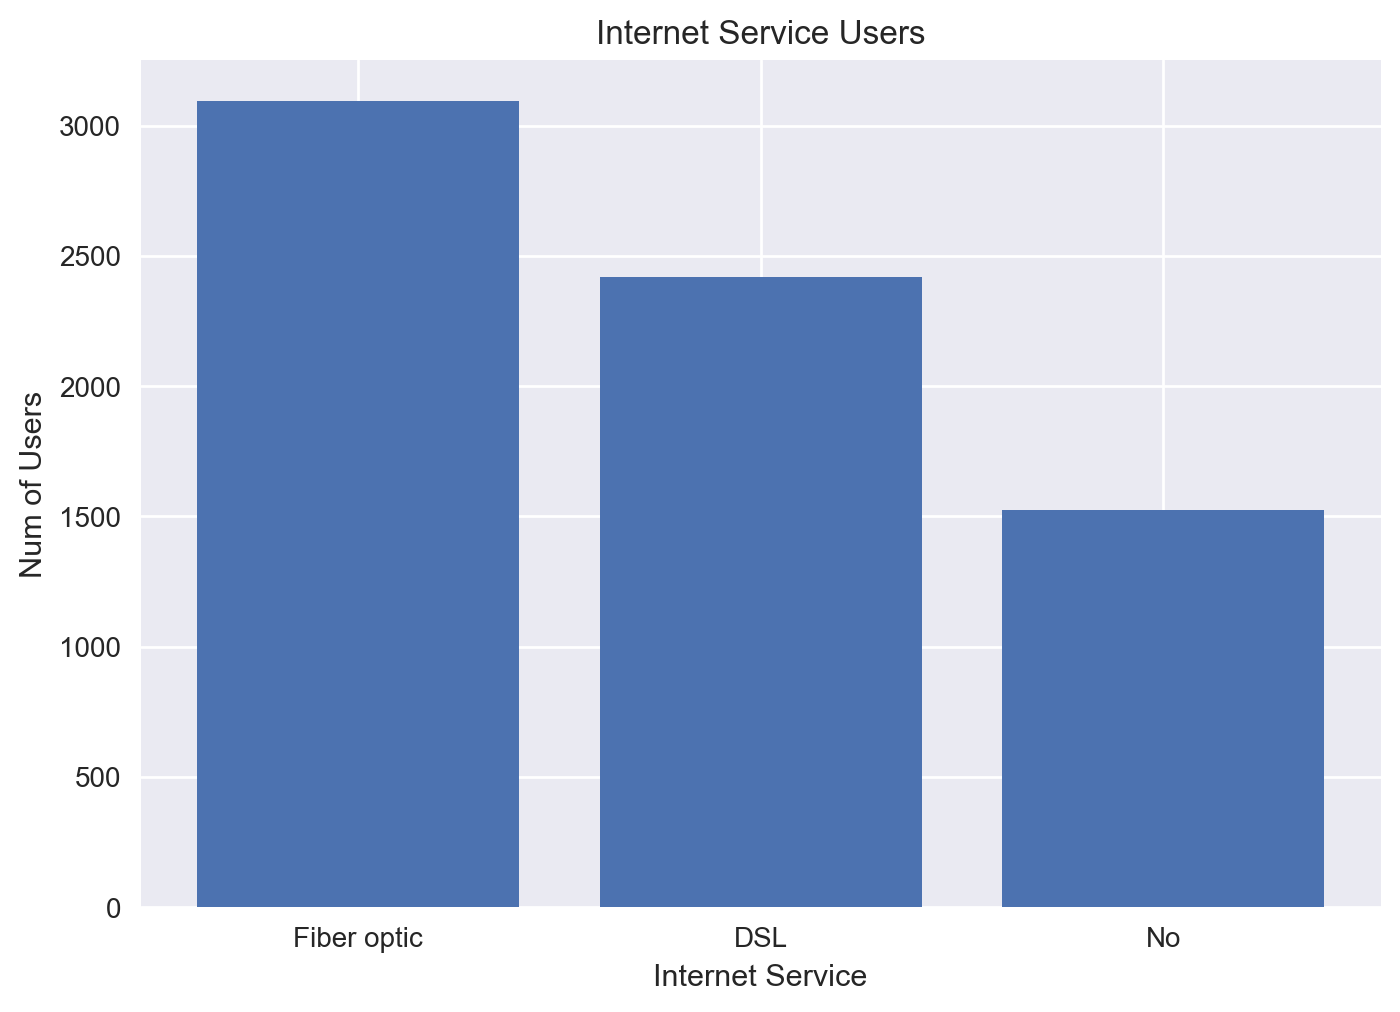

In [38]:
# Plotting paperless_billing values
plt.bar(
    interconnect_full['internet_service'].value_counts().index,
    interconnect_full['internet_service'].value_counts()
)
plt.title('Internet Service Users')
plt.xlabel('Internet Service')
plt.ylabel('Num of Users')

In [39]:
# Group by internet_service and count the number of churned customers
internet_serv_churn = interconnect_full.groupby('internet_service')['churn'].sum()

# Convert the result to a DataFrame for better readability
internet_serv_churn = internet_serv_churn.reset_index()

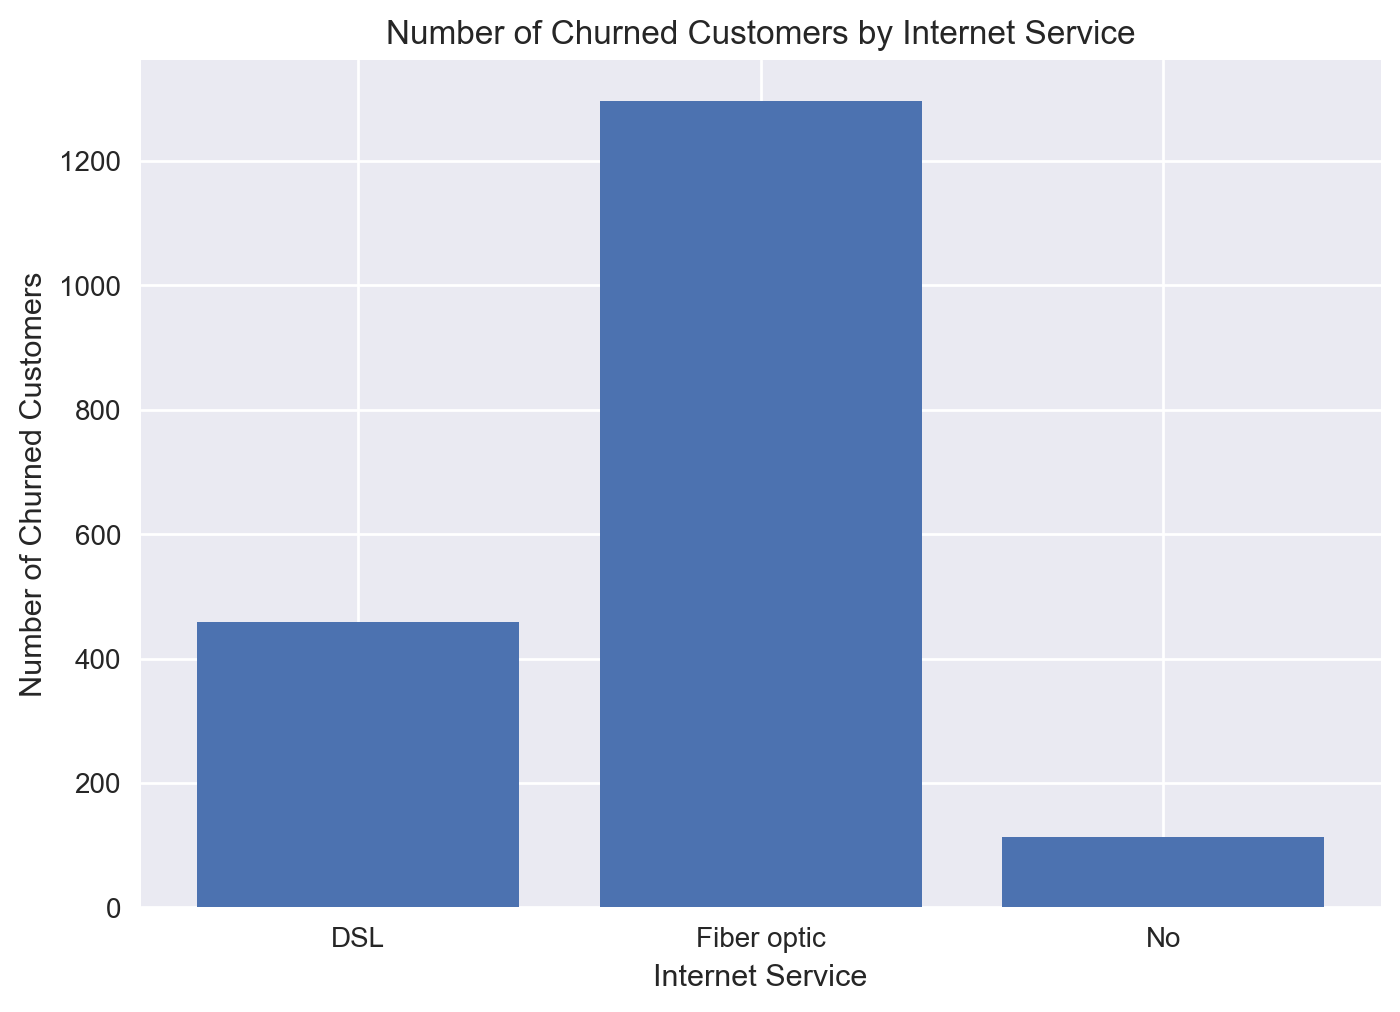

In [40]:
# Plotting churn counts
plt.bar(internet_serv_churn['internet_service'], internet_serv_churn['churn'])
plt.xlabel('Internet Service')
plt.ylabel('Number of Churned Customers')
plt.title('Number of Churned Customers by Internet Service')
plt.show()

Most of the customers who churned had fiber optic internet service. Most customers have fiber optic sothis makes sense but the difference does seem to be disproportianate in the customers who churned.

Text(0, 0.5, 'Num of Users')

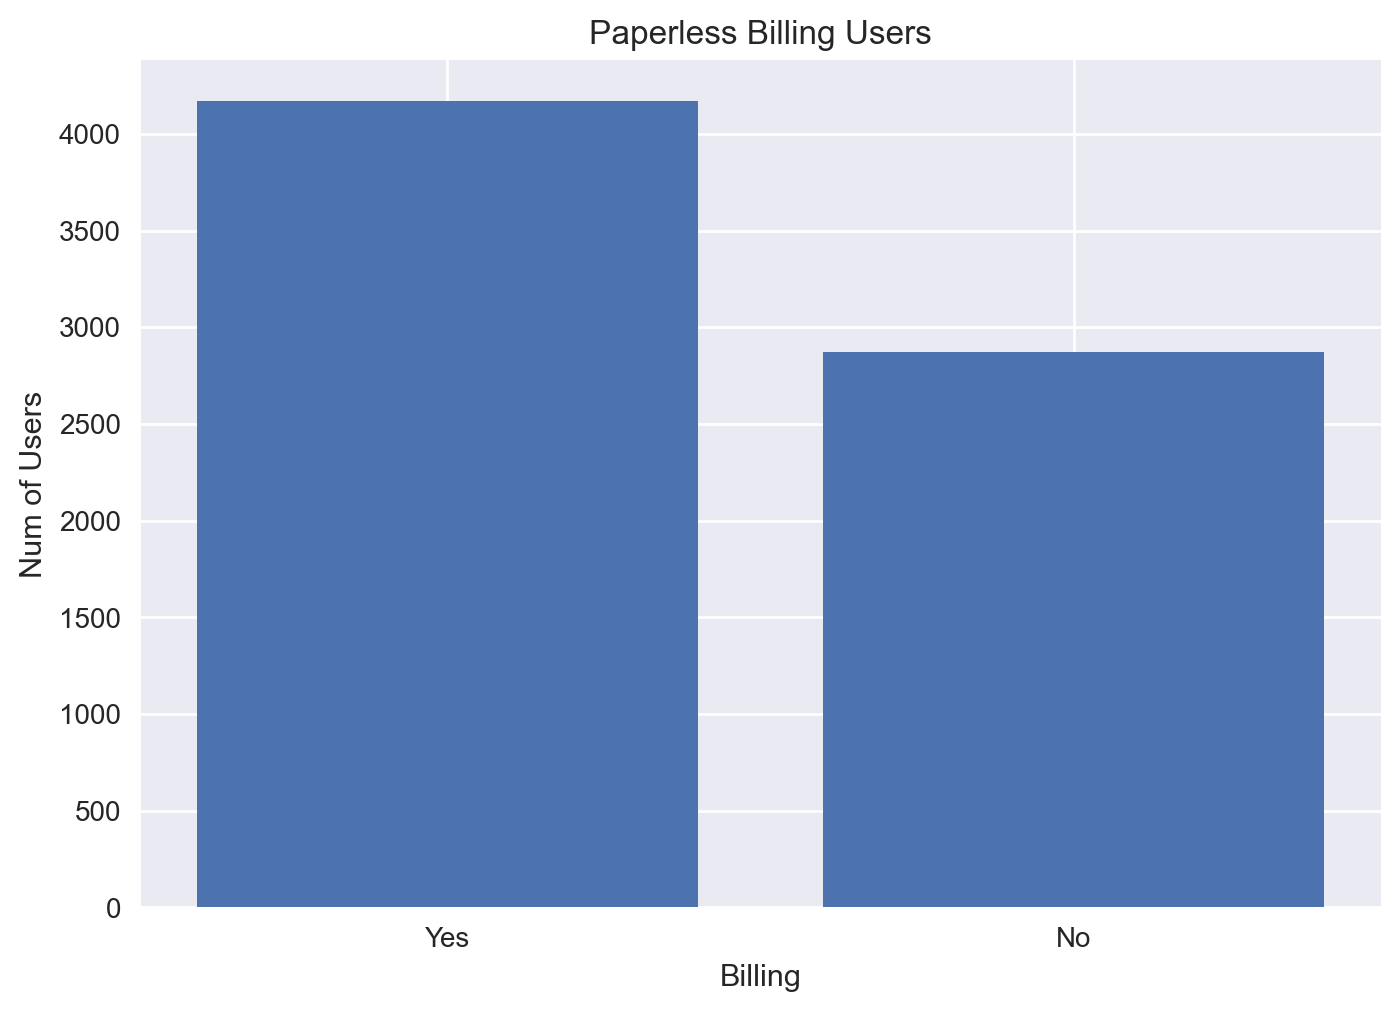

In [41]:
# Plotting paperless_billing values
plt.bar(
    interconnect_full['paperless_billing'].value_counts().index,
    interconnect_full['paperless_billing'].value_counts()
)
plt.title('Paperless Billing Users')
plt.xlabel('Billing')
plt.ylabel('Num of Users')

In [42]:
# Group by paperless_billing and count the number of churned customers
paperless_bill_churn = interconnect_full.groupby('paperless_billing')['churn'].sum()

# Convert the result to a DataFrame for better readability
paperless_bill_churn = paperless_bill_churn.reset_index()

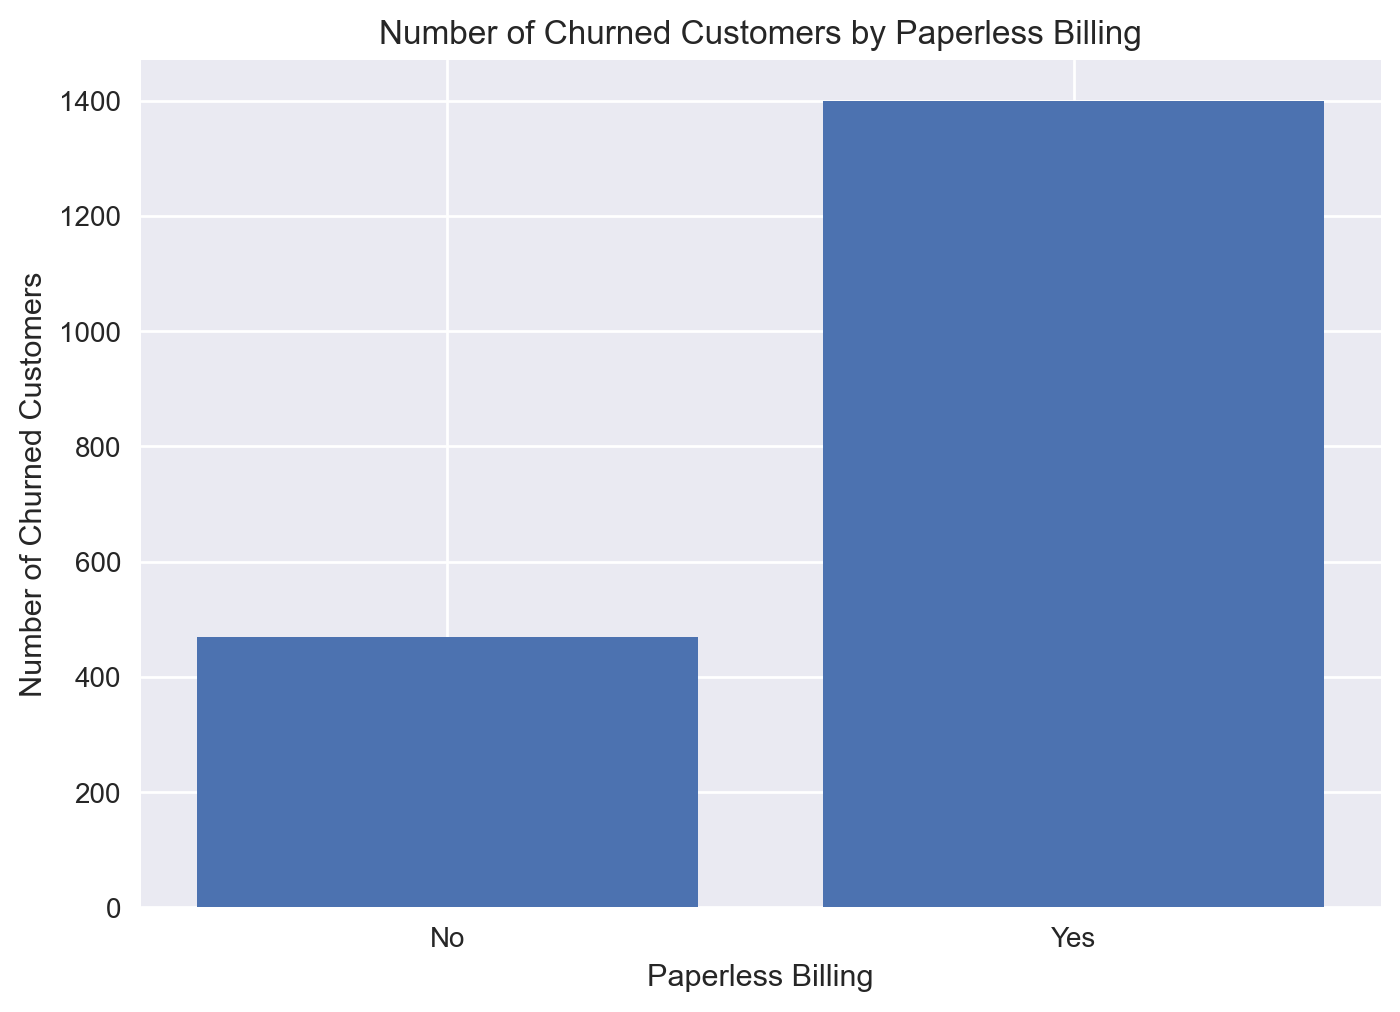

In [43]:
# Plotting churn counts
plt.bar(paperless_bill_churn['paperless_billing'], paperless_bill_churn['churn'])
plt.xlabel('Paperless Billing')
plt.ylabel('Number of Churned Customers')
plt.title('Number of Churned Customers by Paperless Billing')
plt.show()

Seems like people who recieve paper billing may be less likely to churn.

([0, 1, 2, 3],
 [Text(0, 0, 'Electronic check'),
  Text(1, 0, 'Mailed check'),
  Text(2, 0, 'Bank transfer (automatic)'),
  Text(3, 0, 'Credit card (automatic)')])

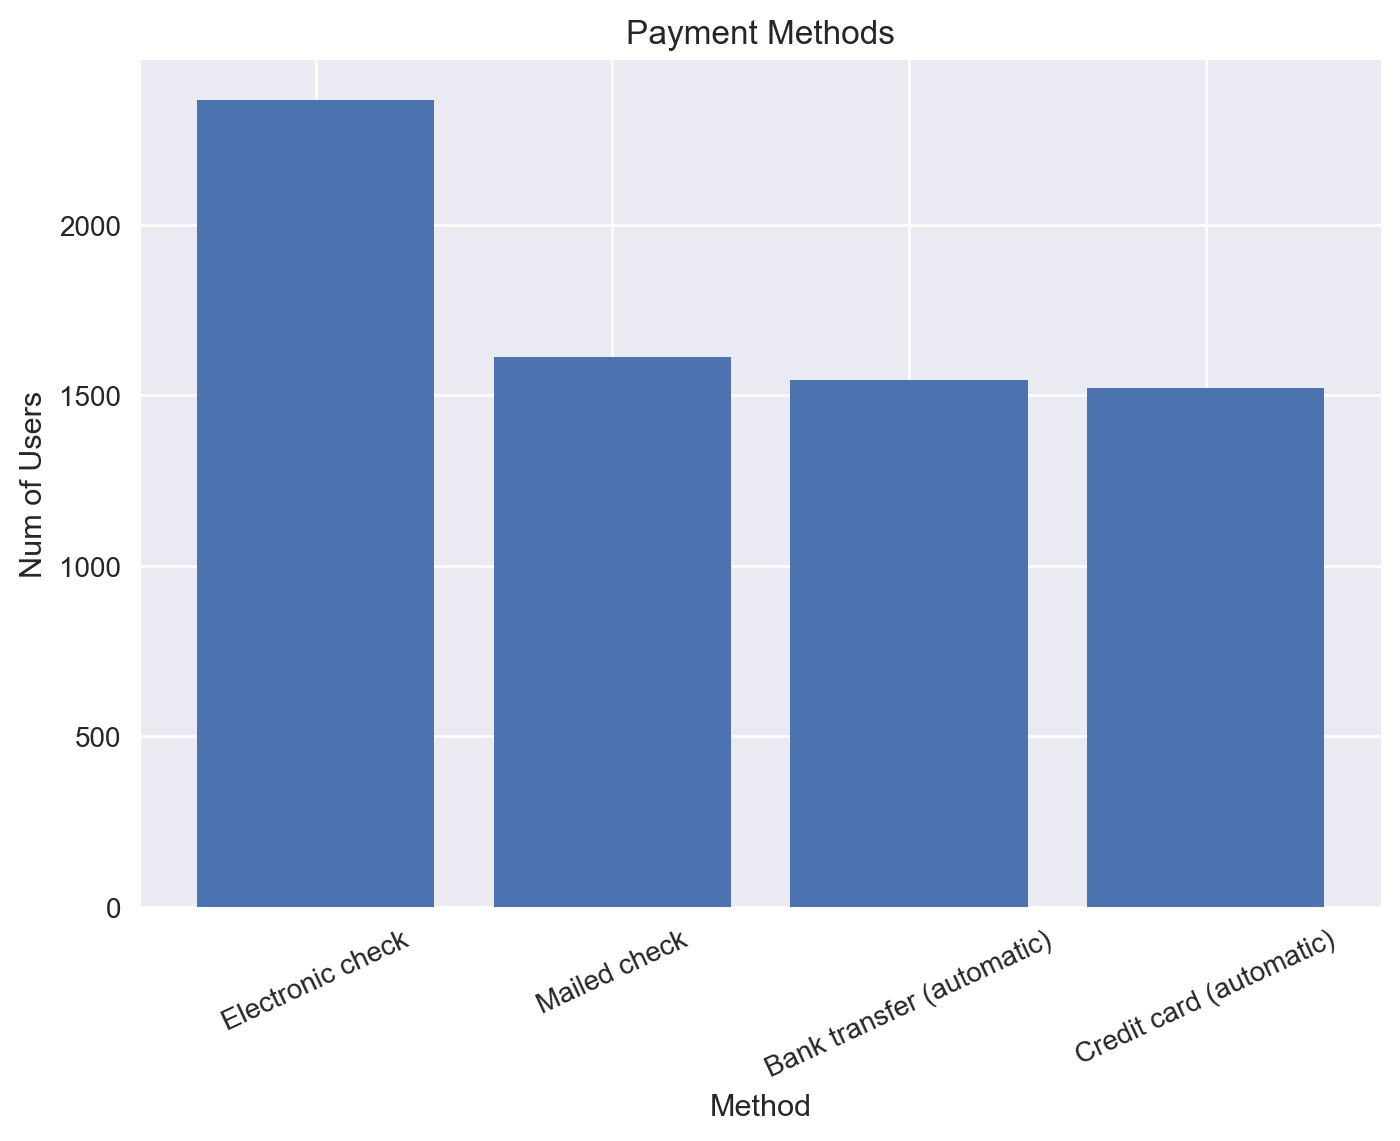

In [44]:
# Plotting payment_method values
plt.bar(
    interconnect_full['payment_method'].value_counts().index,
    interconnect_full['payment_method'].value_counts()
)
plt.title('Payment Methods')
plt.xlabel('Method')
plt.ylabel('Num of Users')
plt.xticks(rotation=25)

In [45]:
# Group by payment_method and count the number of churned customers
payment_method_churn = interconnect_full.groupby('payment_method')['churn'].sum()

# Convert the result to a DataFrame for better readability
payment_method_churn = payment_method_churn.reset_index()

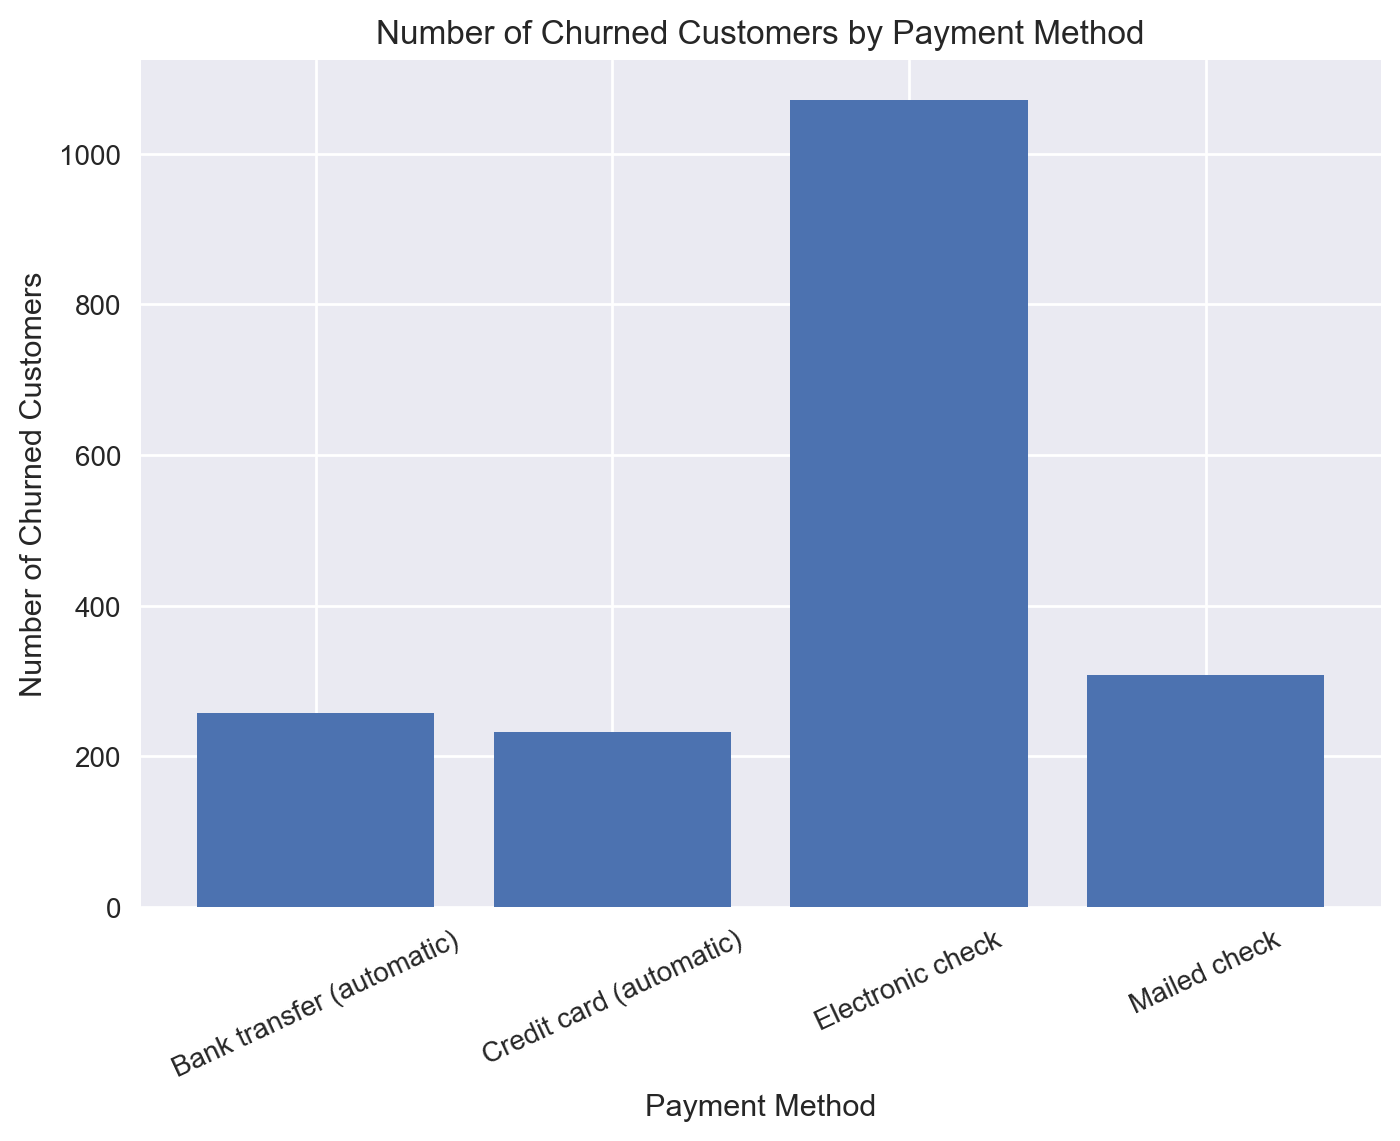

In [46]:
# Plotting churn counts
plt.bar(payment_method_churn['payment_method'], payment_method_churn['churn'])
plt.xlabel('Payment Method')
plt.ylabel('Number of Churned Customers')
plt.title('Number of Churned Customers by Payment Method')
plt.xticks(rotation=25)
plt.show()

Here the contrast is huge. Although there are more customers who pay by check they seem to be much more likely to churn.

([0, 1, 2],
 [Text(0, 0, 'Month-to-month'),
  Text(1, 0, 'Two year'),
  Text(2, 0, 'One year')])

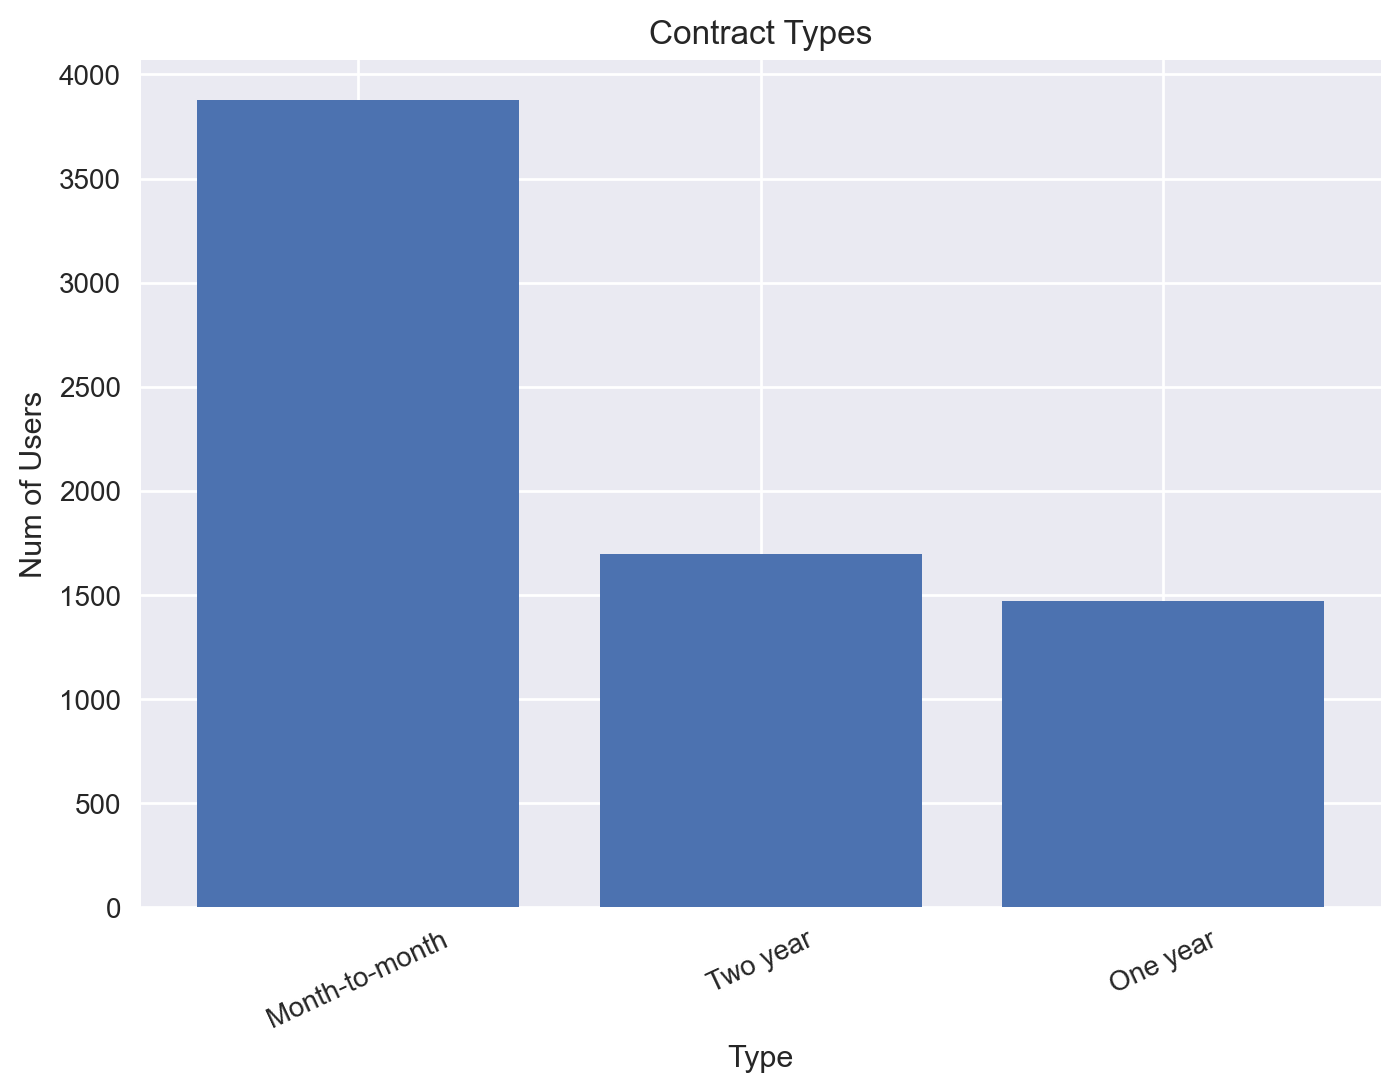

In [47]:
# Plotting type values
plt.bar(
    interconnect_full['type'].value_counts().index,
    interconnect_full['type'].value_counts()
)
plt.title('Contract Types')
plt.xlabel('Type')
plt.ylabel('Num of Users')
plt.xticks(rotation=25)

In [48]:
# Group by payment_method and count the number of churned customers
type_churn = interconnect_full.groupby('type')['churn'].sum()

# Convert the result to a DataFrame for better readability
type_churn = type_churn.reset_index()

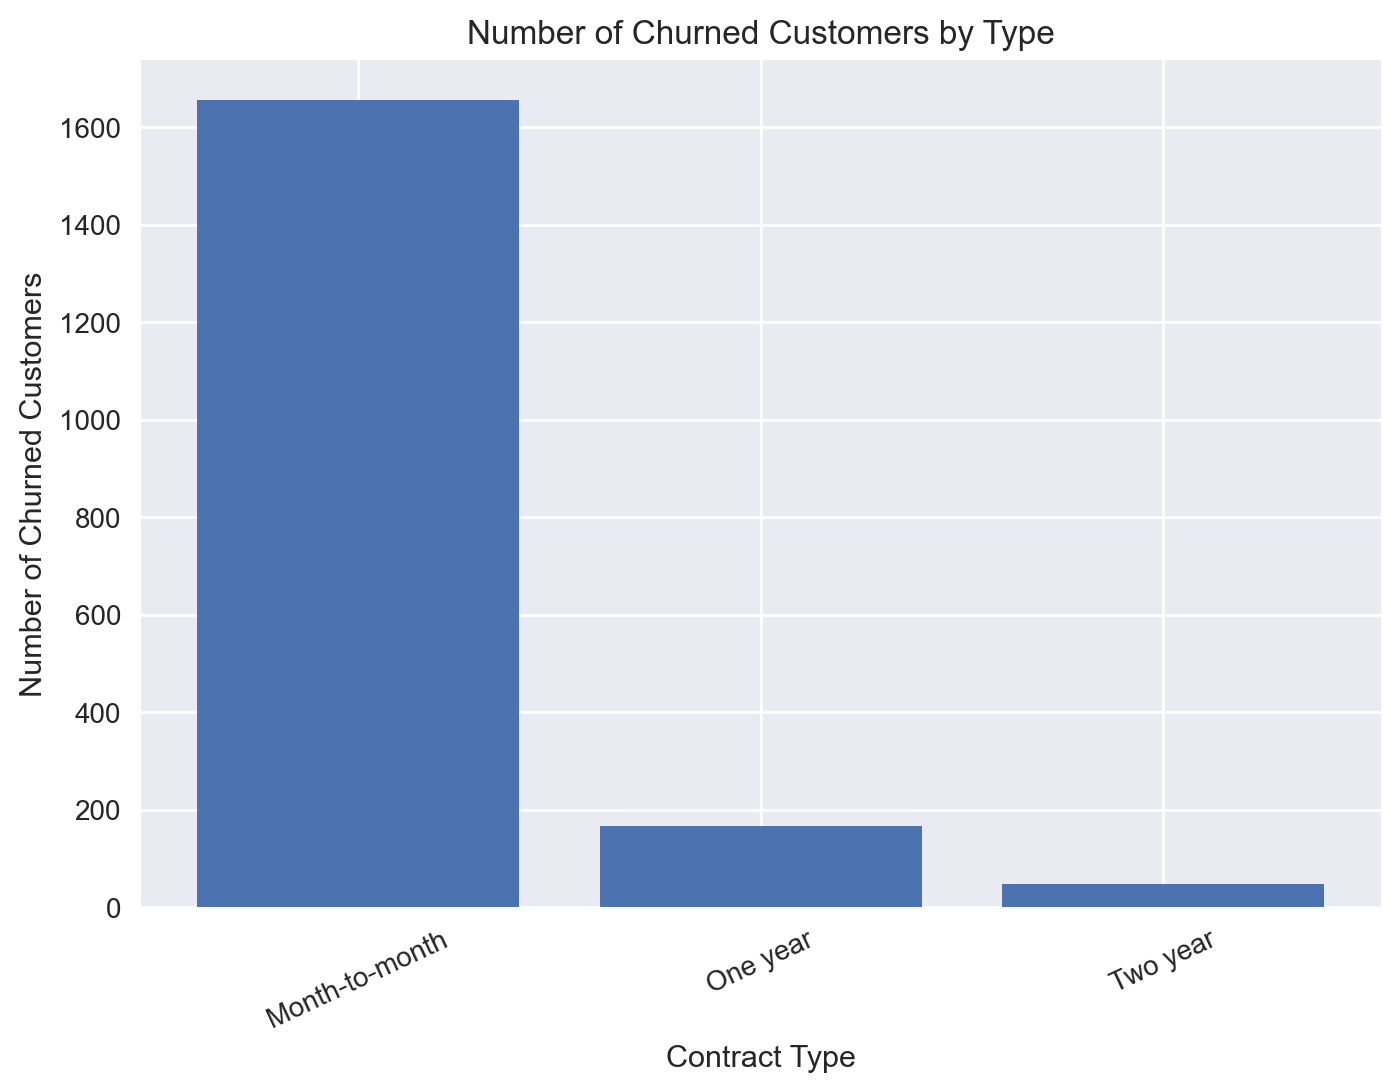

In [49]:
# Plotting churn counts
plt.bar(type_churn['type'], type_churn['churn'])
plt.xlabel('Contract Type')
plt.ylabel('Number of Churned Customers')
plt.title('Number of Churned Customers by Type')
plt.xticks(rotation=25)
plt.show()

Month-to-month customers also seem to be more likely to churn. This makes sense because people who sign up more a longer contract are more likely to be loyal customers.

Text(0, 0.5, 'Frequency')

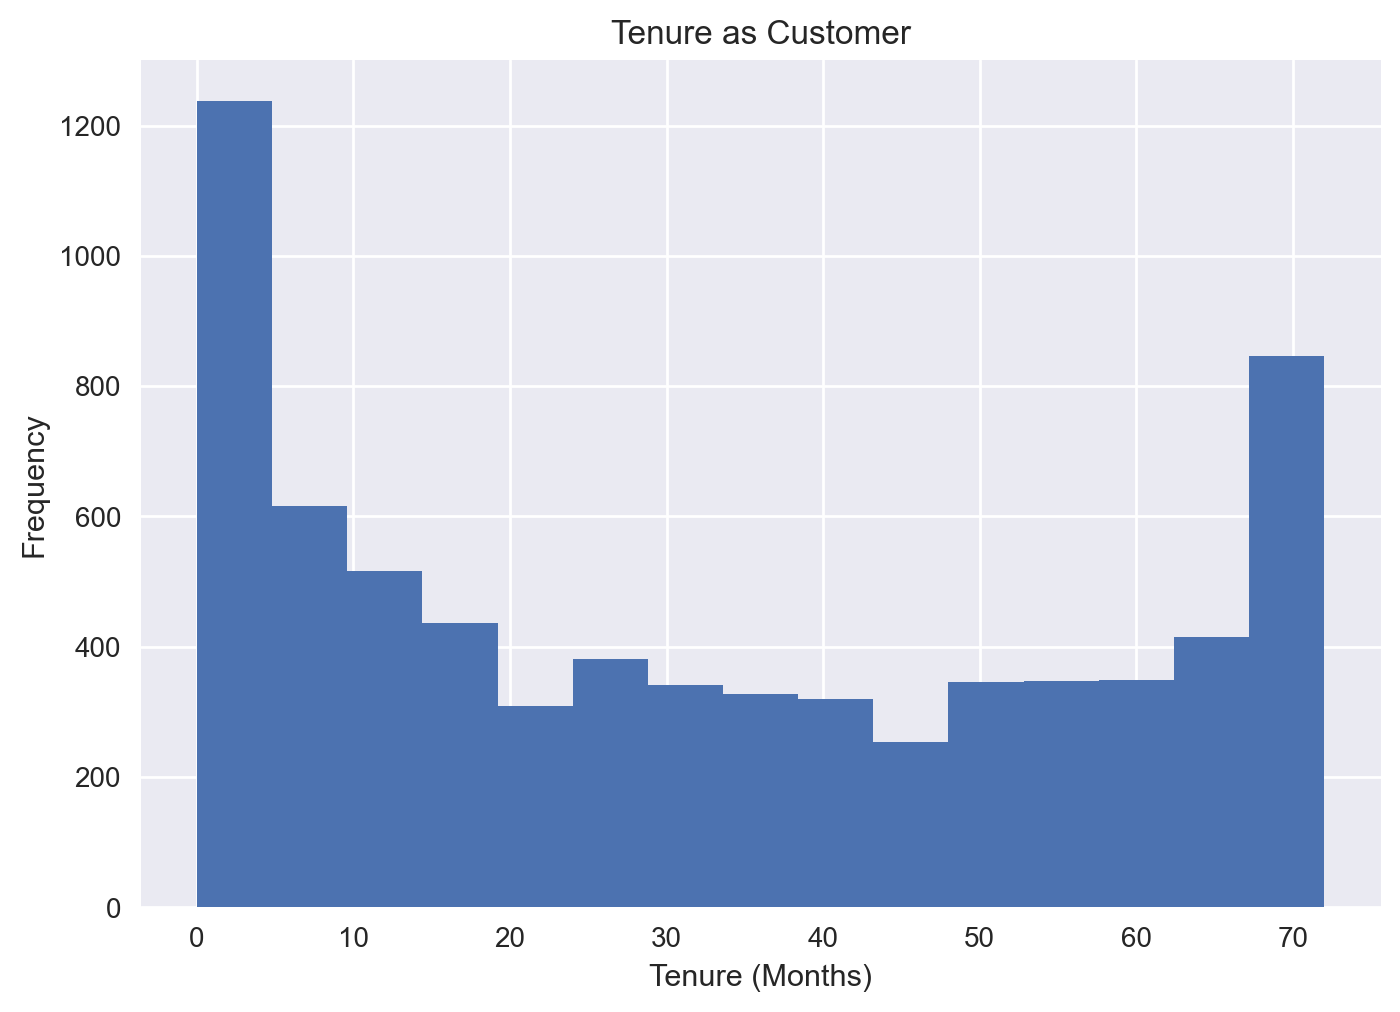

In [50]:
# Plotting Duration histogram
plt.hist(interconnect_full['tenure_months'], bins=15)
plt.title('Tenure as Customer')
plt.xlabel('Tenure (Months)')
plt.ylabel('Frequency')

This duration histogram is quite helpful. It looks like a lot of people churn within a few months. This corresponds with the churn of the month-to-month customers. There is also a spike at 70 months. These are likely to be customers who signed up for longer contracts.

## Encoding Object Data

In [51]:
# Fit and transform customer_id, type, payment_method and internet_service columns
interconnect_encoded = pd.get_dummies(interconnect_full, columns=['type', 'payment_method', 'internet_service',
                                                                  'paperless_billing', 'online_security', 'online_backup',
                                                                  'device_protection', 'tech_support', 'streaming_tv',
                                                                  'streaming_movies', 'partner', 'dependents', 'multiple_lines',
                                                                  'gender'], drop_first=True)

In [52]:
# Checking first 5 rows of new encoded DataFrame 
interconnect_encoded.head()

,customer_id,begin_date,end_date,monthly_charges,total_charges,senior_citizen,churn,tenure_days,tenure_months,avg_monthly_charges,...,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,partner_Yes,dependents_Yes,multiple_lines_Yes,gender_Male
0,7590-VHVEG,2020-01-01,2020-02-01,29.85,29.85,0,0,2678400000000000,1,29.850000,...,False,True,False,False,False,False,True,False,False,False
1,5575-GNVDE,2017-04-01,2020-02-01,56.95,1889.50,0,0,89510400000000000,34,55.573529,...,True,False,True,False,False,False,False,False,False,True
2,3668-QPYBK,2019-10-01,2019-12-01,53.85,108.15,0,1,5270400000000000,2,54.075000,...,True,True,False,False,False,False,False,False,False,True
3,7795-CFOCW,2016-05-01,2020-02-01,42.30,1840.75,0,0,118454400000000000,45,40.905556,...,True,False,True,True,False,False,False,False,False,True
4,9237-HQITU,2019-09-01,2019-11-01,70.70,151.65,0,1,5270400000000000,2,75.825000,...,False,False,False,False,False,False,False,False,False,False


In [53]:
# Checking encoded DataFrame info
interconnect_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   customer_id                             7043 non-null   object        
 1   begin_date                              7043 non-null   datetime64[ns]
 2   end_date                                7043 non-null   datetime64[ns]
 3   monthly_charges                         7043 non-null   float64       
 4   total_charges                           7043 non-null   float64       
 5   senior_citizen                          7043 non-null   int64         
 6   churn                                   7043 non-null   int32         
 7   tenure_days                             7043 non-null   int64         
 8   tenure_months                           7043 non-null   int32         
 9   avg_monthly_charges                     7043 non-nul

Now that all of the data is encoded we're ready to split the data and train the models.

## Training Models

In [54]:
# Creating features and target DataFrames
features = interconnect_encoded.drop(['customer_id', 'begin_date', 'end_date', 'churn'], axis=1)
target = interconnect_encoded['churn']

In [55]:
# Splitting features and target into train, valid and test sets
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=42
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, stratify=target_temp, random_state=42
)

In [56]:
# Defining upsample function
def upsample(features, target, repeat):
    features_zeros = features[target == 0].reset_index(drop=True)
    features_ones = features[target == 1].reset_index(drop=True)
    target_zeros = target[target == 0].reset_index(drop=True)
    target_ones = target[target == 1].reset_index(drop=True)

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [57]:
# Upsampling training data
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [58]:
# Checking shape of each DataFrame
print('features_train shape:', features_train.shape)
print('target_train shape:', target_train.shape)
print('features_upsampled shape:', features_upsampled.shape)
print('target_upsampled shape:', target_upsampled.shape)
print('features_valid shape:', features_valid.shape)
print('target_valid shape:', target_valid.shape)
print('features_test shape:', features_test.shape)
print('target_test shape:', target_test.shape)

features_train shape: (4225, 25)
target_train shape: (4225,)
features_upsampled shape: (6467, 25)
target_upsampled shape: (6467,)
features_valid shape: (1409, 25)
target_valid shape: (1409,)
features_test shape: (1409, 25)
target_test shape: (1409,)


(array([3104.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3363.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

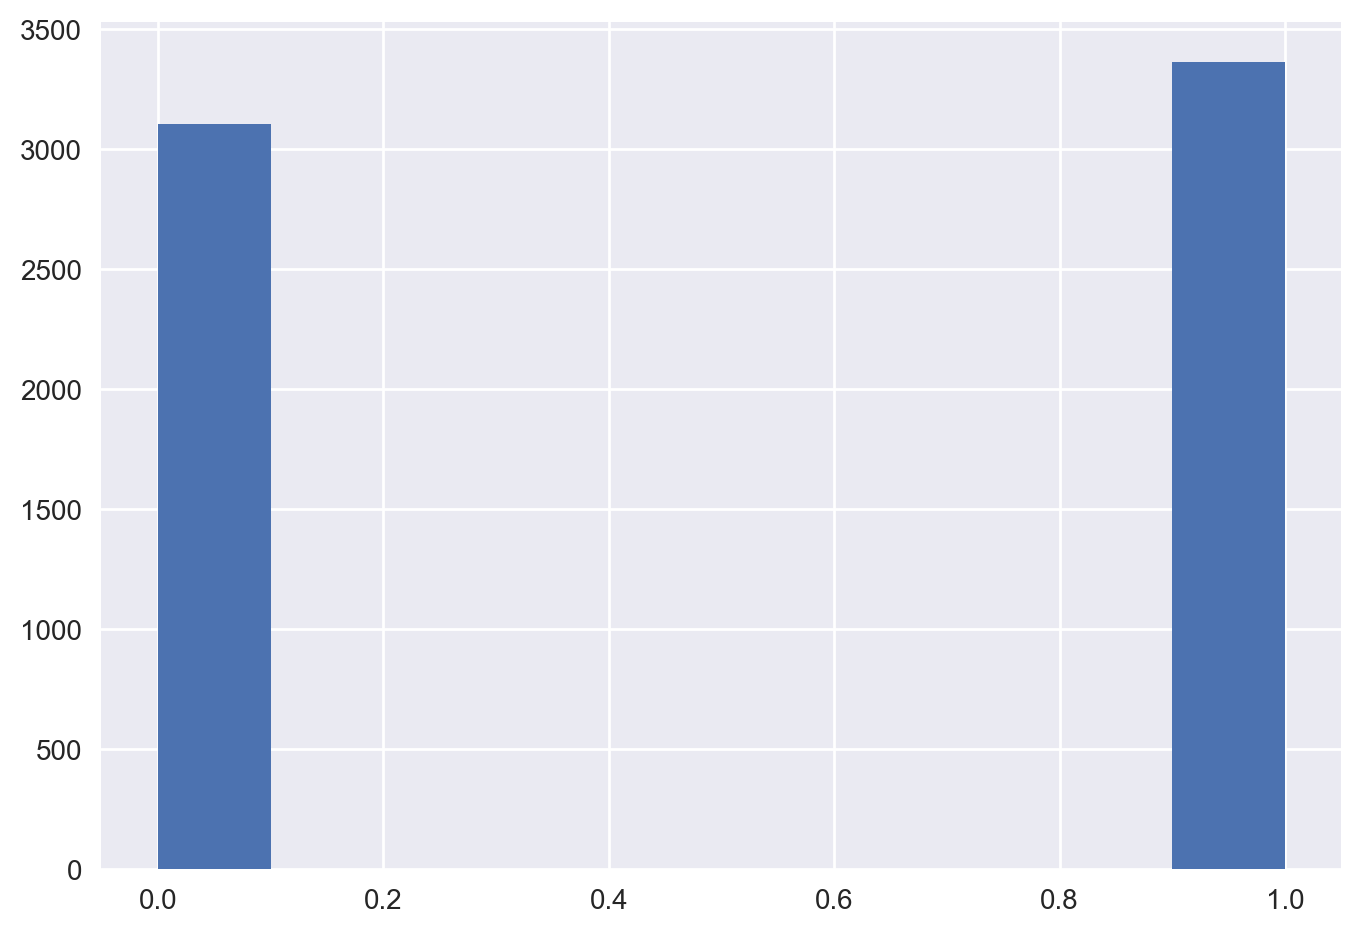

In [59]:
# Checking balance of target_upsampled
plt.hist(target_upsampled)

The training data is much more balanced. This will be important for the models to predict more accurately.

In [60]:
# Train Linear Regression
lr_model = LogisticRegression(max_iter=1500)
lr_model.fit(features_upsampled, target_upsampled)

# Predict with validation set
lr_pred = lr_model.predict(features_valid)
lr_pred_proba = lr_model.predict_proba(features_valid)[:, 1]

# Finding the AUC-ROC of the predictions
lr_auc = roc_auc_score(target_valid, lr_pred_proba)

lr_acc = accuracy_score(target_valid, lr_pred)

print(f'Logistic Regression AUC-ROC: {lr_auc:.2f}, Accuracy Score: {lr_acc:.2f}')

Logistic Regression AUC-ROC: 0.76, Accuracy Score: 0.73


In [61]:
strat_kfold = StratifiedKFold(n_splits=5)

In [62]:
# Define parameter grid for hyperparameter tuning
lgb_param_grid = {
    'num_leaves': [10, 30, 50, 70, 90],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5],
    'min_child_samples': [10, 20, 30, 40, 50]
}

In [63]:
# Initialize a LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Initialize GridSearchCV
lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, scoring='roc_auc',
                               cv=strat_kfold, verbose=1, n_jobs=-1)

# Fit GridSearchCV
lgb_grid_search.fit(features_train, target_train)

# Get the best model
best_lgb_model = lgb_grid_search.best_estimator_

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1121, number of negative: 3104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265325 -> initscore=-1.018470
[LightGBM] [Info] Start training from score -1.018470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [64]:
# Predict with validation set
lgb_pred = best_lgb_model.predict(features_valid)
lgb_pred_proba = best_lgb_model.predict_proba(features_valid)[:, 1]

# Calculate the AUC-ROC Score
best_lgb_auc = roc_auc_score(target_valid, lgb_pred_proba)

# Calculate the Accuracy Score
best_lgb_acc = accuracy_score(target_valid, lgb_pred)

In [65]:
print(f'Best Parameters for Light GBM: {best_lgb_model}')
print(f'Best AUC-ROC Score for Light GBM: {best_lgb_auc:.2f}')
print(f'Best Accuracy Score for Light GBM: {best_lgb_acc:.2f}')

Best Parameters for Light GBM: LGBMClassifier(max_depth=4, min_child_samples=10, n_estimators=400,
               num_leaves=10, random_state=42)
Best AUC-ROC Score for Light GBM: 0.90
Best Accuracy Score for Light GBM: 0.86


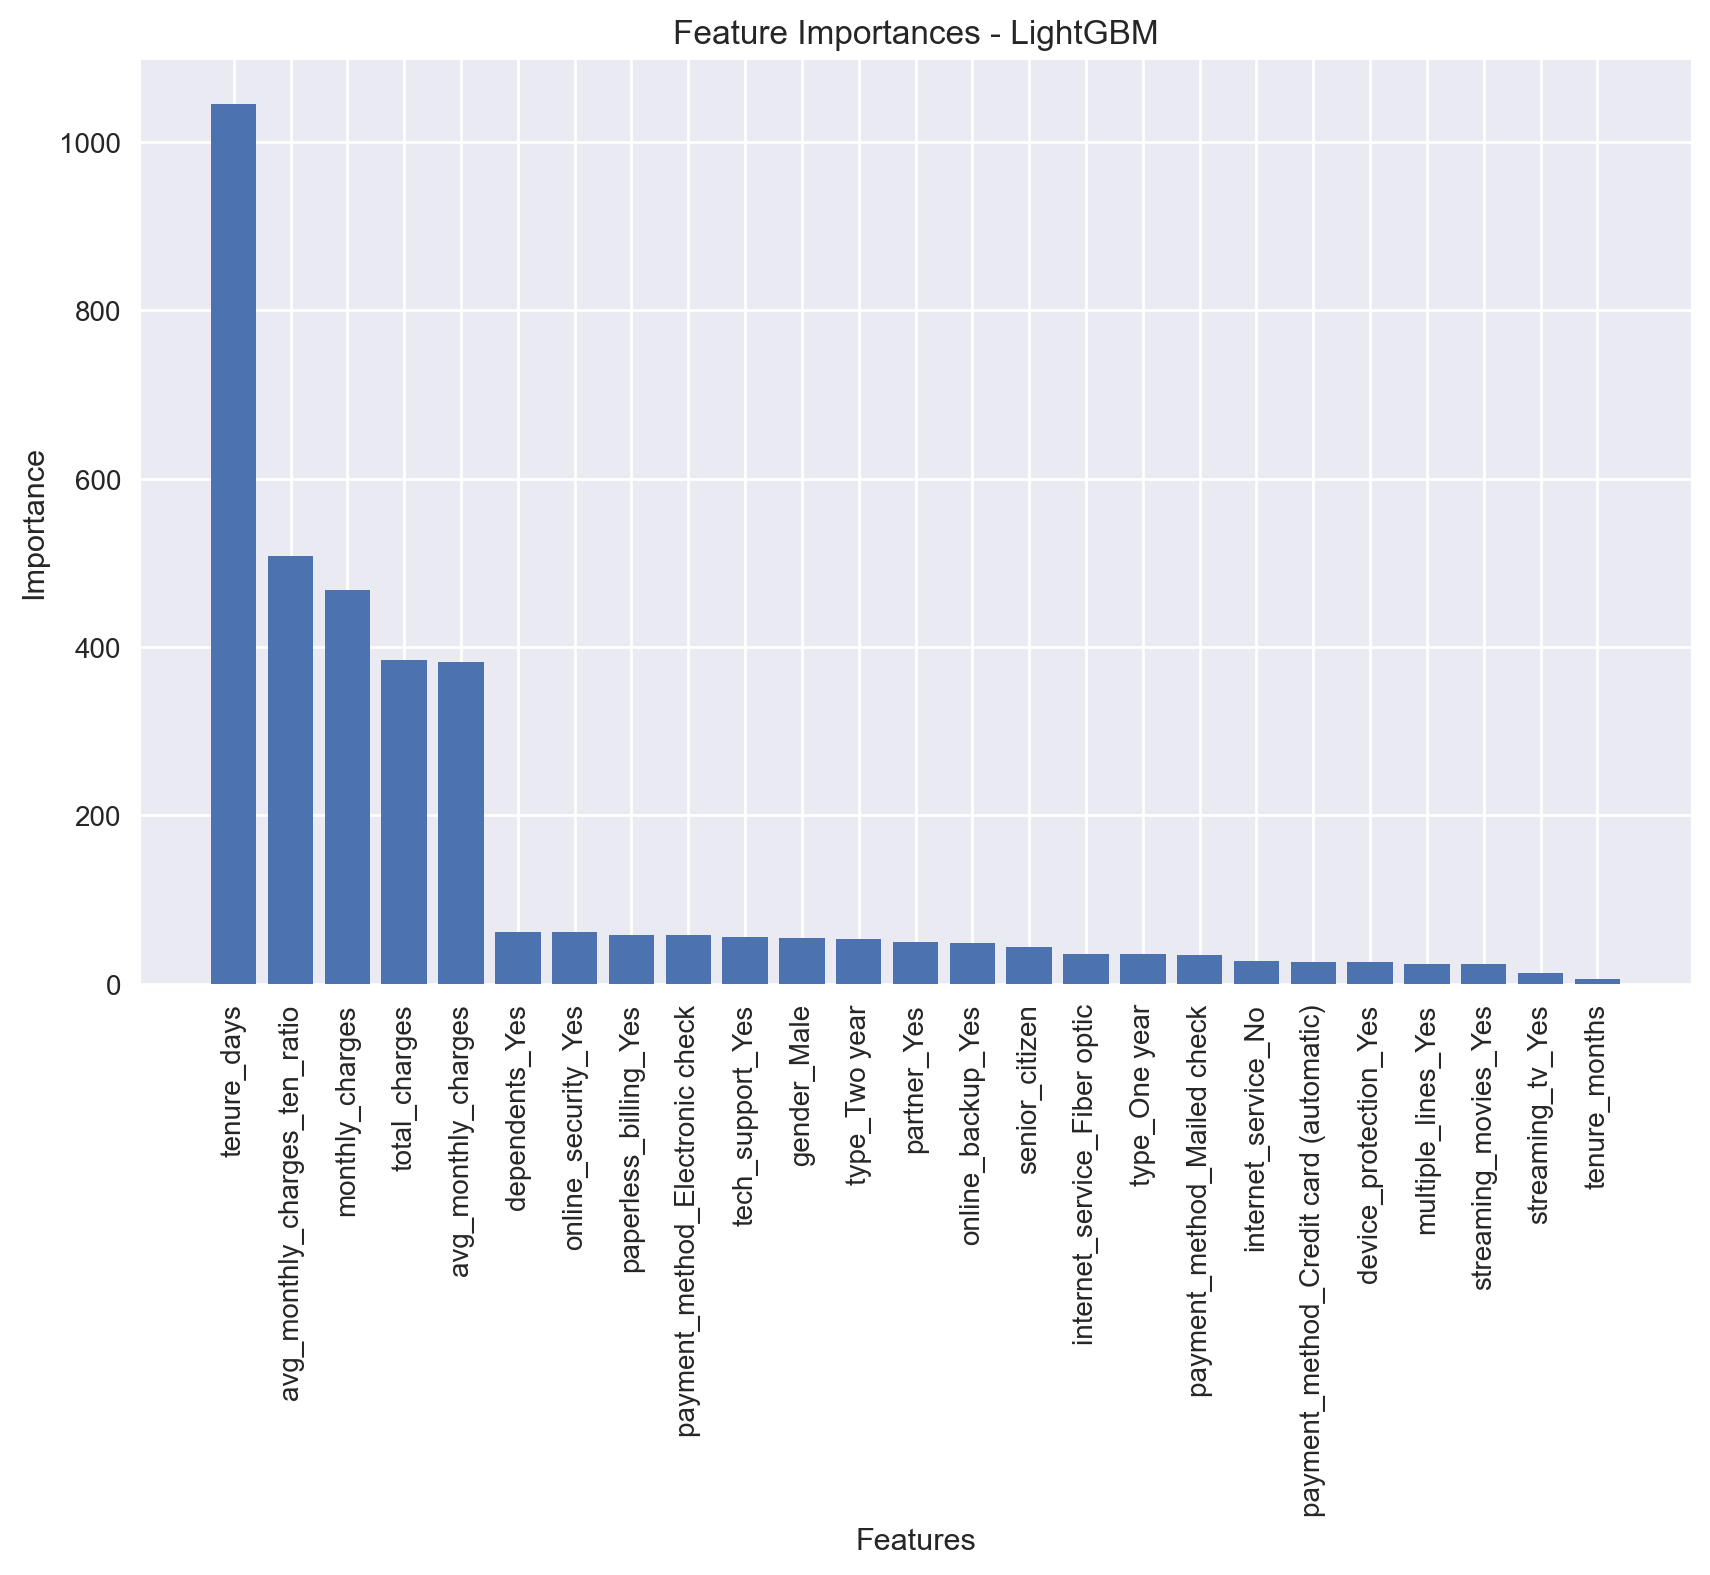

In [66]:
# Plot feature importances for LightGBM
lgb_importances = best_lgb_model.feature_importances_
features = features_train.columns

# Sort the feature importances in descending order
indices = np.argsort(lgb_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances - LightGBM")
plt.bar(range(len(lgb_importances)), lgb_importances[indices], align="center")
plt.xticks(range(len(lgb_importances)), [features[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [67]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

In [68]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Initialize GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='roc_auc',
                               cv=strat_kfold, n_jobs=-1, verbose=1)

# Fit the GridSearchCV model
xgb_grid_search.fit(features_train, target_train)

# Best model
best_xgb_model = xgb_grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\rober\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:59:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [69]:
# Predict with validation set
xgb_pred = best_xgb_model.predict(features_valid)
xgb_pred_proba = best_xgb_model.predict_proba(features_valid)[:, 1]

# Calculate the AUC-ROC Score
best_xgb_auc = roc_auc_score(target_valid, xgb_pred_proba)

# Calculate the Accuracy Score
best_xgb_acc = accuracy_score(target_valid, xgb_pred)

In [70]:
print(f"Best Parameters for XGBoost: {best_xgb_model}")
print(f"Best AUC-ROC Score for XGBoost: {best_xgb_auc:.2f}")
print(f"Best Accuracy Score for XGBoost: {best_xgb_acc:.2f}")

Best Parameters for XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Best AUC-ROC Score for XGBoost: 0.91
Best Accuracy Score for XGBoost: 0.87


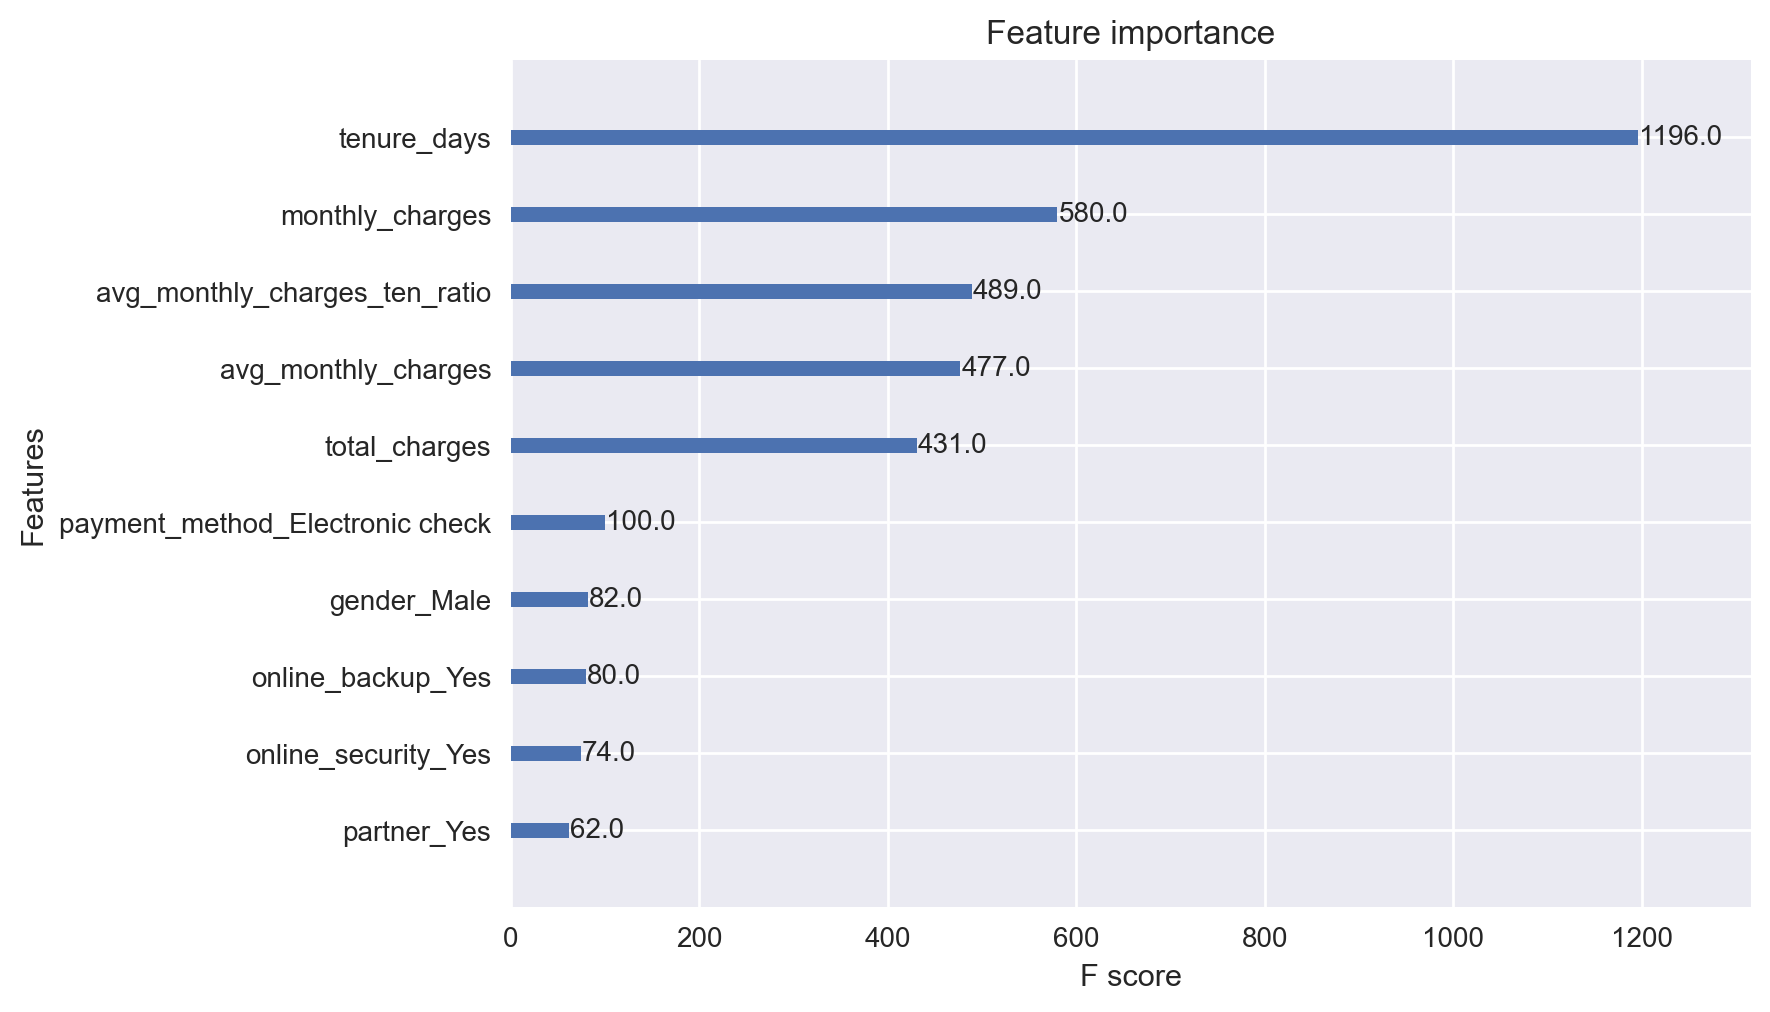

In [71]:
# Alternatively, use XGBoost's built-in plot function
plot_importance(best_xgb_model, max_num_features=10, importance_type='weight')
plt.show()

In [72]:
# Define the parameter grid for CatBoost
cat_param_grid = {
    'iterations': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

In [73]:
# Initialize the CatBoost classifier
cat_model = CatBoostClassifier(verbose=0)

# Initialize GridSearchCV
cat_grid_search = GridSearchCV(estimator=cat_model, param_grid=cat_param_grid, scoring='roc_auc',
                               cv=strat_kfold, n_jobs=-1, verbose=1)

# Fit the GridSearchCV model
cat_grid_search.fit(features_train, target_train)

# Best model
best_cat_model = cat_grid_search.best_estimator_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [74]:
# Predict with validation set
cat_pred = best_cat_model.predict(features_valid)
cat_pred_proba = best_cat_model.predict_proba(features_valid)[:, 1]

# Calculate the AUC-ROC Score
best_cat_auc = roc_auc_score(target_valid, cat_pred_proba)

# Calculate the Accuracy Score
best_cat_acc = accuracy_score(target_valid, cat_pred)

In [75]:
print(f"Best Parameters for CatBoost: {best_cat_model.get_params()}")
print(f"Best AUC-ROC Score for CatBoost: {best_cat_auc:.2f}")
print(f"Best Accuracy Score for CatBoost: {best_cat_acc:.2f}")

Best Parameters for CatBoost: {'iterations': 500, 'learning_rate': 0.2, 'depth': 3, 'verbose': 0}
Best AUC-ROC Score for CatBoost: 0.92
Best Accuracy Score for CatBoost: 0.88


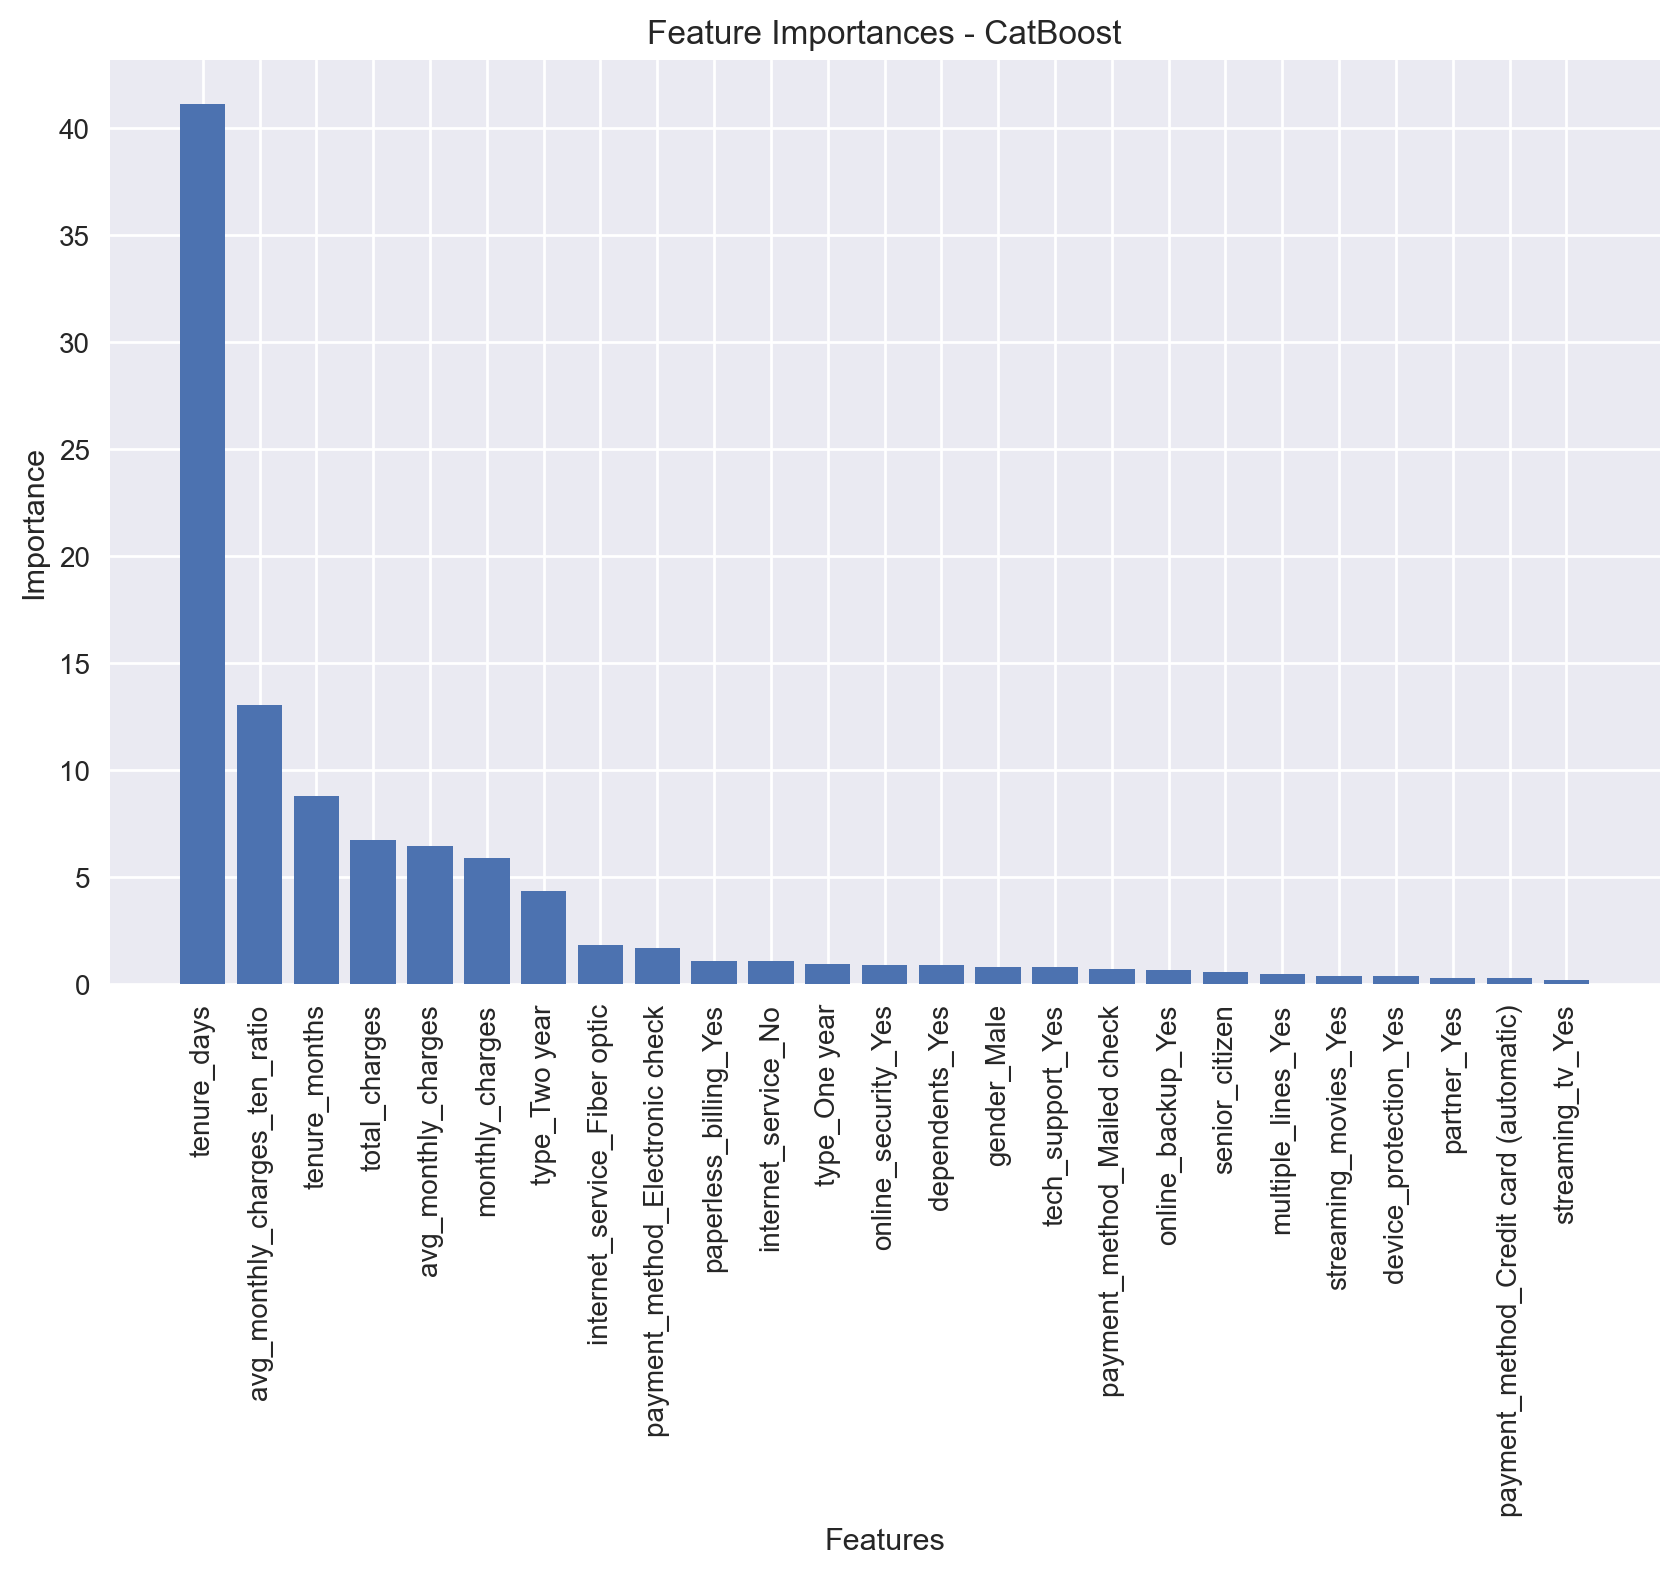

In [76]:
# Plot feature importances for CatBoost
cat_importances = best_cat_model.get_feature_importance()
features = features_train.columns

# Sort the feature importances in descending order
indices = np.argsort(cat_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances - CatBoost")
plt.bar(range(len(cat_importances)), cat_importances[indices], align="center")
plt.xticks(range(len(cat_importances)), [features[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

The CatBoost model performed better than the other models and surpasses the AUC-ROC threshold by a comfortable margin.

## Testing Models

In [77]:
# Getting Final Logistic Regression Predictions and scores
final_lr_pred = lr_model.predict(features_test)
final_lr_pred_proba = lr_model.predict_proba(features_test)[:, 1]
final_lr_auc = roc_auc_score(target_test, final_lr_pred_proba)
final_lr_acc = accuracy_score(target_test, final_lr_pred)

print(f'Final Logistic Regression AUC-ROC Score: {final_lr_auc:.2f}. Final Accuracy Score: {final_lr_acc:.2f}')

Final Logistic Regression AUC-ROC Score: 0.74. Final Accuracy Score: 0.73


In [78]:
# Getting final Light GBM predictions and scores
final_lgb_pred = best_lgb_model.predict(features_test)
final_lgb_pred_proba = best_lgb_model.predict_proba(features_test)[:, 1]
final_lgb_auc = roc_auc_score(target_test, final_lgb_pred_proba)
final_lgb_acc = accuracy_score(target_test, final_lgb_pred)

print(f'Final Light GBM AUC-ROC Score: {final_lgb_auc:.2f}, Final Accuracy Score: {final_lgb_acc:.2f}')

Final Light GBM AUC-ROC Score: 0.89, Final Accuracy Score: 0.85


In [79]:
# Getting final XGBoost predictions and scores
final_xgb_pred = best_xgb_model.predict(features_test)
final_xgb_pred_proba = best_xgb_model.predict_proba(features_test)[:, 1]
final_xgb_auc = roc_auc_score(target_test, final_xgb_pred_proba)
final_xgb_acc = accuracy_score(target_test, final_xgb_pred)

print(f'Final XGBoost AUC-ROC Score: {final_xgb_auc:.2f}, Final Accuracy Score: {final_xgb_acc:.2f}')

Final XGBoost AUC-ROC Score: 0.89, Final Accuracy Score: 0.84


In [80]:
# Getting final CatBoost predictions and scores
final_cat_pred = best_cat_model.predict(features_test)
final_cat_pred_proba = best_cat_model.predict_proba(features_test)[:, 1]
final_cat_auc = roc_auc_score(target_test, final_cat_pred_proba)
final_cat_acc = accuracy_score(target_test, final_cat_pred)

print(f'Final CatBoost AUC-ROC Score: {final_cat_auc:.2f}, Final Accuracy Score: {final_cat_acc:.2f}')

Final CatBoost AUC-ROC Score: 0.90, Final Accuracy Score: 0.85


## Conclusions

All three of the boosting models reached the AUC-ROC goal. The CatBoost model performed the best by a small amount. The goal was to get an AUC-ROC score above 0.88 and the CatBoost model was able to get an AUC-ROC score of 0.90 on the test set. The accuracy scores of each model boosting seemed to be pretty similar. However, AUC-ROC is a better metric because it takes into account false positive rate. Interconnect should aim to reduce false positives to avoid losing money from promotions on customers who won't churn.

With this model Interconnect will be able to successfully predict customers who will churn and save them with promotions and special programs. The model can also identify the features that were most predictive of churn. This will help the company to make decisions to minimize the risk of churn.

I've included the final scores below for easy comparison. 

<b>Logistic Regression</b>

    AUC-ROC Score: 0.74
    Accuracy Score: 0.73
    
<b>Light GBM</b>

    AUC-ROC Score: 0.89
    Accuracy Score: 0.85
    
<b>XGBoost</B>

    AUC-ROC Score: 0.89
    Accuracy Score: 0.84
    
<b>CatBoost</b>

    AUC-ROC Score: 0.90
    Accuracy Score: 0.85

# Project Report

### Steps Taken

These were the original steps in my plan:
<ol>
    <li>Download data</li>
    <li>Explore data for preprocessing</li>
    <li>Preprocess data</li>
    <ul>
        <li>Merge datasets</li>
        <li>Change column names to snake case</li>
        <li>Handle missing values</li>
        <li>Correct dtypes</li>
    </ul>
    <li>Perform EDA to get a deeper understanding</li>
    <li>Perform feature engineering</li>
    <ul>
        <li>Extract target data from EndDate</li>
        <li>Encode object type columns</li>
        <li>Extract date info from BeginDate and EndDate</li>
    </ul>
    <li>Create train, validation and test sets</li>
    <li>Perform class balancing</li>
    <li>Use Logistic Regression as base model</li>
    <li>Train 2-3 other models to choose best model</li>
    <li>Tune model hyperparameters to reach AUC-ROC threshold</li>
    <li>Get model test scores</li>
    <li>Write conclusions</li>
</ol>


I would say that I followed my plan pretty closely. I did do a few additional things though that made an  impact on my project. The features that I proposed in the begining were not sufficient. Instead of extracting the date info from BeginDate and EndDate I used those dates to calculate the amount of time that each customer was using their service. This turned out to be crucial for the predictions of my models. I also created an average_monthly_charges feature and I then used that feature to create another feature calculating the ratio of average monthly charges and months of service.

### Difficulties Encountered

The biggest dificulty that I had was determining what features I could create that would be useful to my models. What helped me overcome this was plotting the features that the models were already considering important. This helped me to get new ideas that ultimately were what made my models reach the AUC-ROC threshold.

I also struggled with choosing hyperparameters that would be not only effective but more efficient to be able to save time in running my code. I overcame this essentially with some good ole fashioned experimentation and learning about new tools for testing hyperparameter tuning such as GridSearchCV.

### Key Step To Solving The Task

The key steps to solving the task were the ones that I struggled with the most.

The features that I engineered turned out to be much more predictive of churn than most of the original features. The feature 'tenure_days' was the number one predictive feature for all three of my boosting models.

EDA was crucial to understand how different features effected churn. For example, plotting the distribution of tenure of customers helped me understand the link between tenure and churn.

Tuning model hyperparameters was also essential. Using GridSearchCV I was able find hyperparameters that were most effective. It took quite abit of trial and error to choose the right hyperparameters to add to the grid that would be effective.

### Final Model

My final model was CatBoost. I calculated both the AUC-ROC and accuracy scores however, I find AUC-Roc to be a more important metric for this task because it takes into account false positive rates. I believe that this is important so that interconnect does not special offers to as many customers who would stay without these additional incentives.

<b>CatBoost</b>

    AUC-ROC Score: 0.90
    Accuracy Score: 0.85